In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
import pandas as pd
import seaborn as sns

import torch 
from torch.optim import SGD

In [2]:
def generate_regression_samples(num_examples, num_features):
    orig_weight = np.random.randn(num_features)
    orig_bias = np.random.randn(1)
    
    x = np.random.randn(num_examples, num_features)
    y = np.array([x[i]@orig_weight + orig_bias + np.random.randn(1) for i in range(num_examples)])
    return x, y, orig_weight, orig_bias

1. Stochastic gradient descent update are - 
    
    $w$ = $w$ - $(\eta/\beta)$*$\sum_{i\in\beta}x^{(i)}(w^Tx^{(i)} + b- y^{(i)})$ 

    $b$ = $b$ - $(\eta/\beta)$*$\sum_{i\in\beta}(w^Tx^{(i)} + b- y^{(i)})$ 

    where $\eta$ is the learning rate and $\beta$ is  the batch size.

2. Parameters that are tunable but not updated in the training loop are called hyperparameters. Hyperparameter tuning is the process by which hyperparameters are chosen, and typically requires that we adjust them basedon the results of the training loop as assessed on a separate validation dataset (or validation set).


In [3]:
# batch generator, mainly used so that we can take benefit of GPU's, and it is memory efficient as well 
# although we can form dataloaders from here
def make_batches(batch_size, features, labels):
    num_examples = labels.shape[0]
    indices = list(range(num_examples))
    # randomly shuffling the examples first
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = indices[i:min(i+batch_size, num_examples)]
        yield features[batch_indices], labels[batch_indices] 
        ## more about yield  - https://www.geeksforgeeks.org/python-yield-keyword/ 

In [4]:
# all initialized as tensors
def forward(x, w, b):
    #data_x = torch.tensor(x, dtype=torch.float32)
    return x@w + b

def loss(y, yhat):
    return torch.sum((y-yhat.reshape(y.shape[0], 1))**2)/2

def init_params(num_features):
    w = torch.randn((num_features, 1), requires_grad=True)
    b = torch.randn((1), requires_grad=True)
    return [w, b]

In [5]:
def train_make_batches(x, y, num_epochs, lr, batch_size, params, optimizer):
    w = params[0]
    b = params[1]
    losses =  []
    data_x = torch.tensor(x, dtype=torch.float32)
    data_y = torch.tensor(y, dtype=torch.float32)
    for epoch in range(num_epochs):
        losses.append(loss(data_y, forward(data_x, w, b)).item()) # this step won't be affective when the dataset is larger, we can instead do the sum of all the bacthes and take their averages    
        if epoch%(num_epochs/10)==0:
            print(f'epoch {epoch + 1}, loss {float(losses[-1]):f}')
        #total_loss  =0
        #batches_processed = 0
        for x_batch, y_batch in  make_batches(batch_size, data_x, data_y):
            current_loss = loss(forward(x_batch, w, b), y_batch)
            #total_loss+= current_loss.item()
            
            optimizer.zero_grad()
            current_loss.backward()
            optimizer.step()
            #batches_processed+= 1
    return losses

In [6]:
# instead of using the make_batches() function we couold have used the dataloader function from pytorch
def train_using_dataloader(x, y, num_epochs, lr, batch_size, params, optimizer):
    w = params[0]
    b = params[1]
    losses =  []
    data_x = torch.tensor(x, dtype=torch.float32)
    data_y = torch.tensor(y, dtype=torch.float32)
    dataset = torch.concat((data_x, data_y), axis=1)
    for epoch in range(num_epochs):
        losses.append(loss(torch.unsqueeze(dataset[:, 1],1), forward(torch.unsqueeze(dataset[:, 0], 1), w, b)).item()) # this step won't be affective when the dataset is larger, we can instead do the sum of all the bacthes and take their averages    
        if epoch%(num_epochs/10)==0:
            print(f'epoch {epoch + 1}, loss {float(losses[-1]):f}')
        #total_loss  =0
        #batches_processed = 0
        for batch in  torch.utils.data.DataLoader(dataset , batch_size=batch_size):
            # remember batch will be a tensor of (batch_size, 2)
            current_loss = loss(forward(torch.unsqueeze(batch[:, 0], 1), w, b),torch.unsqueeze(batch[:, 1], 1))
            #total_loss+= current_loss.item()
            
            optimizer.zero_grad()
            current_loss.backward()
            optimizer.step()
            #batches_processed+= 1
    return losses

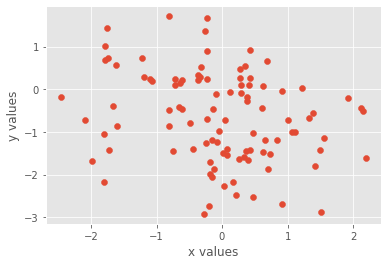

In [7]:
# hyperparameters
num_features = 1 # for generating synthetic data for regression 
num_examples = 99 # for generating synthetic data

num_epochs = 50
batch_size = 10
params = init_params(num_features)
lr = 0.001
optimizer = SGD(params=params, lr=lr)

# data for training
x, y, orig_w, orig_b = generate_regression_samples(99, 1)
style.use("ggplot")
plt.scatter(x, y)
plt.xlabel("x values")
plt.ylabel("y values")
plt.show()

epoch 1, loss 438.384766
epoch 6, loss 201.080383
epoch 11, loss 109.531548
epoch 16, loss 74.179550
epoch 21, loss 60.514523
epoch 26, loss 55.226460
epoch 31, loss 53.177292
epoch 36, loss 52.381809
epoch 41, loss 52.072239
epoch 46, loss 51.951336


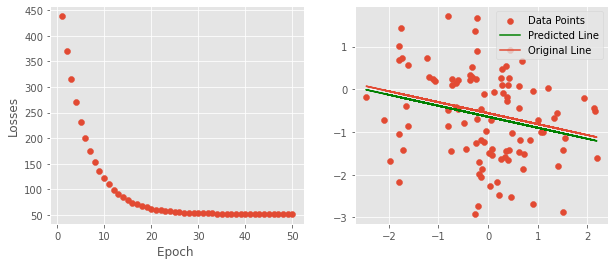

In [8]:
losses = train_using_dataloader(x, y, num_epochs=num_epochs, lr=lr, batch_size=batch_size, params=params, optimizer=optimizer)            
plt.figure(figsize=(10, 4))
plt.subplot(1,2, 1)
style.use("ggplot")
plt.scatter(range(1, num_epochs+1), losses)
plt.xlabel("Epoch ")
plt.ylabel("Losses")
plt.subplot(1,2,2)
style.use("ggplot")
plt.scatter(x, y)
plt.plot(x, forward(x, params[0].detach().numpy(), params[1].detach().numpy()), 'g')
plt.plot(x, forward(x, orig_w, orig_b))
plt.legend(['Data Points', 'Predicted Line', 'Original Line'])

#plt.legend()
plt.show()

In [9]:
params

[tensor([[-0.2578]], requires_grad=True),
 tensor([-0.6451], requires_grad=True)]

In [10]:
[orig_w, orig_b]

[array([-0.25692483]), array([-0.55945988])]